In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
reps = [nx.random_regular_graph(d=2, n=10) for i in range(3)]

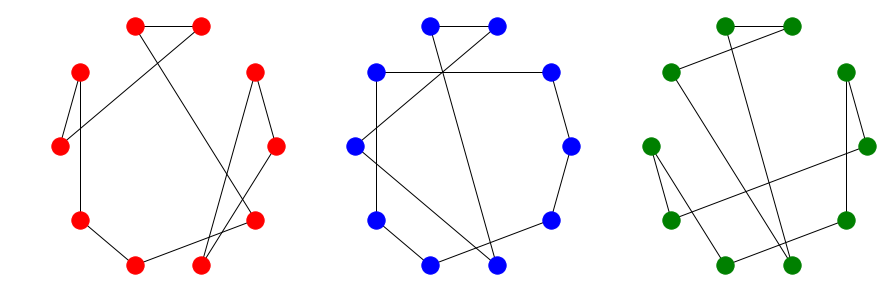

In [3]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
colors = ['red', 'blue', 'green']
for i,r in enumerate(reps):
    nx.draw_circular(r, ax=axs[i], node_color=colors[i])
plt.savefig("cluster_representative.png", transparent=True, dpi=200, bbox_inches='tight')
plt.show()

In [23]:
adjacencies = []
for i in range(3):
    A = nx.adjacency_matrix(reps[i]).todense().astype(float)
    A[np.where(A!=0)]= np.random.rand(np.where(A!=0)[0].size)*0.45
    np.fill_diagonal(A, 1)
    adjacencies.append(A)

In [25]:
from regain.utils import is_pos_def

In [29]:
is_pos_def(adjacencies[2])

True

In [34]:
np.linalg.norm(adjacencies[0]-adjacencies[1])**2

1.488057378179761

In [35]:
np.sum(adjacencies[0]-adjacencies[1])

0.2311923344875096

In [39]:
np.nonzero(diff_12)[0].shape[0]

28

In [30]:
diff_12 = adjacencies[0]-adjacencies[1]
diff_12


matrix([[ 0.        ,  0.2939972 ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.23476521, -0.26364733],
        [ 0.21026518,  0.        ,  0.        ,  0.        , -0.37971072,
          0.        ,  0.        ,  0.        ,  0.44115918,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.04282627,  0.        ,
         -0.1586294 ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.11341166,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        , -0.01258348,  0.01803175],
        [ 0.        , -0.14608057,  0.        ,  0.        ,  0.        ,
          0.44808359,  0.21954725,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.00761785,  0.        ,  0.20277653,
          0.        ,  0.        ,  0.        , -0.24401693,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.00762807,
          0.        ,  0.       

In [32]:
diff_23 = adjacencies[1]-adjacencies[2]
diff_23

matrix([[ 0.        , -0.21823748,  0.        ,  0.        ,  0.        ,
          0.        , -0.30669319,  0.        ,  0.        ,  0.26364733],
        [ 0.07515902,  0.        ,  0.        ,  0.        ,  0.37971072,
          0.        ,  0.        ,  0.        ,  0.        , -0.16421115],
        [ 0.        ,  0.        ,  0.        , -0.02825361, -0.0832227 ,
          0.2161974 ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        , -0.21529282,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        , -0.37931535,  0.        ],
        [ 0.        ,  0.14608057, -0.19427387,  0.        ,  0.        ,
          0.        ,  0.08538963,  0.        , -0.38482865,  0.        ],
        [ 0.        ,  0.        ,  0.03641928,  0.        ,  0.        ,
          0.        , -0.28641672, -0.25275283,  0.24401693,  0.        ],
        [-0.42310638,  0.        ,  0.        ,  0.        ,  0.26225542,
         -0.02767181,  0.       